In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime


%matplotlib inline
from RL_env.config import config
from RL_env.marketdata.yahoodownloader import YahooDownloader
from RL_env.preprocessing.preprocessors import FeatureEngineer
from RL_env.preprocessing.data import data_split
from RL_env.env.env_stocktrading import StockTradingEnv
from RL_env.model.models import DRLAgent,DRLEnsembleAgent
from RL_env.trade.backtest import backtest_stats, get_baseline, backtest_plot
from RL_env.trade.backtest import convert_daily_return_to_pyfolio_ts,get_daily_return


from pprint import pprint
from pyfolio import timeseries

import sys
sys.path.append("../FinRL-Library")

import itertools

In [2]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [3]:
start_date=config.START_DATE
end_date=config.END_DATE

In [4]:
df = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = config.PRO2_5_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (26420, 8)


In [5]:
# df.to_csv('susa.csv')

In [6]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2000-01-03,49.75000,49.87500,48.750000,28.029879,721300,CLX,0
1,2000-01-03,17.50000,17.50000,17.031250,6.980553,5351200,PEG,0
2,2000-01-03,30.50000,30.53125,28.750000,19.372763,778600,SPGI,0
3,2000-01-03,10.25000,10.31250,10.000000,7.615736,383100,STE,0
4,2000-01-03,4.85326,4.85326,4.567774,1.312247,14974,VTR,0


In [7]:
df.tail(10)

,date,open,high,low,close,volume,tic,day
26410,2020-12-30,201.990005,202.460007,200.960007,198.818573,787300,CLX,2
26411,2020-12-30,56.959999,57.669998,56.959999,56.840031,1188100,PEG,2
26412,2020-12-30,322.709991,324.290009,320.760010,322.226440,1340000,SPGI,2
26413,2020-12-30,186.440002,187.970001,185.460007,185.482803,169100,STE,2
26414,2020-12-30,48.990002,49.830002,48.570000,48.011890,1382000,VTR,2
26415,2020-12-31,201.610001,202.050003,199.899994,199.688858,947800,CLX,3
26416,2020-12-31,57.279999,58.340000,57.189999,57.771507,1860400,PEG,3
26417,2020-12-31,324.299988,328.850006,323.309998,327.304321,1014200,SPGI,3
26418,2020-12-31,187.270004,189.699997,184.889999,188.718704,234800,STE,3
26419,2020-12-31,48.419998,49.080002,47.799999,48.636711,1701400,VTR,3


In [8]:
df.shape

(26420, 8)

In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = True)

df = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added user defined features


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4
0,2000-01-03,49.75000,49.87500,48.750000,28.029879,721300,CLX,0,0.0,28.713661,26.598151,0.0,-66.666667,100.0,28.029879,28.029879,-0.750960,-1.390143,-0.026684
5284,2000-01-03,17.50000,17.50000,17.031250,6.980553,5351200,PEG,0,0.0,28.713661,26.598151,0.0,-66.666667,100.0,6.980553,6.980553,-0.750960,-1.390143,-0.026684
10568,2000-01-03,30.50000,30.53125,28.750000,19.372763,778600,SPGI,0,0.0,28.713661,26.598151,0.0,-66.666667,100.0,19.372763,19.372763,1.775248,1.020740,-0.026684
15852,2000-01-03,10.25000,10.31250,10.000000,7.615736,383100,STE,0,0.0,28.713661,26.598151,0.0,-66.666667,100.0,7.615736,7.615736,-0.606884,-0.933652,-0.026684
21136,2000-01-03,4.85326,4.85326,4.567774,1.312247,14974,VTR,0,0.0,28.713661,26.598151,0.0,-66.666667,100.0,1.312247,1.312247,-0.827693,-1.758476,-0.026684


In [11]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i,:]
    price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    covs = return_lookback.cov().values 
    cov_list.append(covs)

df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [12]:
df.shape

(25160, 20)

In [13]:
df.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,35.375000,35.375000,34.375000,20.012337,1145400,CLX,1,-1.440794,25.595107,15.733454,42.102959,-53.008050,18.662144,22.672172,23.801964,8.116402,2.210075,-0.029930,"[[0.0012963581910900742, 0.0001124400663364624..."
1,2001-01-02,24.250000,24.250000,23.312500,10.184226,1143600,PEG,1,0.388193,11.104872,9.150192,59.783849,72.402367,18.511712,9.730554,9.304631,-0.491103,-0.675509,-0.039846,"[[0.0012963581910900742, 0.0001124400663364624..."
2,2001-01-02,29.250000,29.250000,28.187500,19.149103,593000,SPGI,1,0.036161,20.015698,17.862836,48.125619,65.173392,15.059239,18.802057,19.651690,0.880271,0.631416,-0.031983,"[[0.0012963581910900742, 0.0001124400663364624..."
3,2001-01-02,16.000000,16.750000,15.875000,12.393305,266800,STE,1,0.230339,12.723289,10.464493,57.782918,156.000649,21.678489,11.603351,11.447253,-0.352800,-0.435099,0.015504,"[[0.0012963581910900742, 0.0001124400663364624..."
4,2001-01-02,6.352061,6.780290,6.352061,2.292767,228120,VTR,1,0.092696,2.225830,1.764660,66.063306,152.666251,21.668769,1.890896,1.846461,-0.815000,-1.687397,0.044445,"[[0.0012963581910900742, 0.0001124400663364624..."
5,2001-01-03,35.000000,35.375000,33.312500,19.467533,1586300,CLX,2,-1.363240,24.861126,15.900842,40.761527,-56.254983,24.540892,22.428828,23.721648,7.490847,2.138989,-0.027223,"[[0.0012964710975455912, 0.0001212698551307669..."
6,2001-01-03,23.343750,23.750000,21.468750,9.407114,2640200,PEG,2,0.282122,11.072264,9.206696,49.491304,1.795765,16.390223,9.750187,9.310633,-0.516779,-0.727282,-0.076305,"[[0.0012964710975455912, 0.0001212698551307669..."
7,2001-01-03,28.281250,28.937500,27.906250,19.317818,1567400,SPGI,2,0.043874,19.988530,18.027084,49.172309,54.095591,9.445844,18.795738,19.628232,1.053533,0.719562,0.008811,"[[0.0012964710975455912, 0.0001212698551307669..."
8,2001-01-03,16.250000,16.625000,15.875000,12.062185,433500,STE,2,0.224077,12.770388,10.497808,55.467956,120.142151,21.678489,11.612812,11.471692,-0.375593,-0.470952,-0.026718,"[[0.0012964710975455912, 0.0001212698551307669..."
9,2001-01-03,6.780290,7.708119,6.780290,2.585459,595476,VTR,2,0.127812,2.366422,1.705177,72.191023,250.838387,44.906069,1.919469,1.859595,-0.785656,-1.540173,0.127659,"[[0.0012964710975455912, 0.0001212698551307669..."


In [14]:
train = data_split(df, config.START_DATE,'2019-01-01')
trade = data_split(df, '2019-01-02', config.END_DATE)

In [15]:
train.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2001-01-02,35.375000,35.375000,34.375000,20.012337,1145400,CLX,1,-1.440794,25.595107,15.733454,42.102959,-53.008050,18.662144,22.672172,23.801964,8.116402,2.210075,-0.029930,"[[0.0012963581910900742, 0.0001124400663364624..."
0,2001-01-02,24.250000,24.250000,23.312500,10.184226,1143600,PEG,1,0.388193,11.104872,9.150192,59.783849,72.402367,18.511712,9.730554,9.304631,-0.491103,-0.675509,-0.039846,"[[0.0012963581910900742, 0.0001124400663364624..."
0,2001-01-02,29.250000,29.250000,28.187500,19.149103,593000,SPGI,1,0.036161,20.015698,17.862836,48.125619,65.173392,15.059239,18.802057,19.651690,0.880271,0.631416,-0.031983,"[[0.0012963581910900742, 0.0001124400663364624..."
0,2001-01-02,16.000000,16.750000,15.875000,12.393305,266800,STE,1,0.230339,12.723289,10.464493,57.782918,156.000649,21.678489,11.603351,11.447253,-0.352800,-0.435099,0.015504,"[[0.0012963581910900742, 0.0001124400663364624..."
0,2001-01-02,6.352061,6.780290,6.352061,2.292767,228120,VTR,1,0.092696,2.225830,1.764660,66.063306,152.666251,21.668769,1.890896,1.846461,-0.815000,-1.687397,0.044445,"[[0.0012963581910900742, 0.0001124400663364624..."
1,2001-01-03,35.000000,35.375000,33.312500,19.467533,1586300,CLX,2,-1.363240,24.861126,15.900842,40.761527,-56.254983,24.540892,22.428828,23.721648,7.490847,2.138989,-0.027223,"[[0.0012964710975455912, 0.0001212698551307669..."
1,2001-01-03,23.343750,23.750000,21.468750,9.407114,2640200,PEG,2,0.282122,11.072264,9.206696,49.491304,1.795765,16.390223,9.750187,9.310633,-0.516779,-0.727282,-0.076305,"[[0.0012964710975455912, 0.0001212698551307669..."
1,2001-01-03,28.281250,28.937500,27.906250,19.317818,1567400,SPGI,2,0.043874,19.988530,18.027084,49.172309,54.095591,9.445844,18.795738,19.628232,1.053533,0.719562,0.008811,"[[0.0012964710975455912, 0.0001212698551307669..."
1,2001-01-03,16.250000,16.625000,15.875000,12.062185,433500,STE,2,0.224077,12.770388,10.497808,55.467956,120.142151,21.678489,11.612812,11.471692,-0.375593,-0.470952,-0.026718,"[[0.0012964710975455912, 0.0001212698551307669..."
1,2001-01-03,6.780290,7.708119,6.780290,2.585459,595476,VTR,2,0.127812,2.366422,1.705177,72.191023,250.838387,44.906069,1.919469,1.859595,-0.785656,-1.540173,0.127659,"[[0.0012964710975455912, 0.0001212698551307669..."


In [16]:
train.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
4525,2018-12-28,153.889999,154.889999,151.600006,144.311737,614300,CLX,4,-2.099239,161.947477,138.348611,47.866205,-113.312214,18.825712,151.097902,146.702275,1.777050,1.021389,-0.000392,"[[0.00024402977214695831, 8.234504305654115e-0..."
4525,2018-12-28,51.599998,51.970001,51.070000,47.532215,2167700,PEG,4,-0.701865,53.448395,46.289694,43.330744,-132.462702,25.816342,49.779550,49.608305,-0.670628,-1.110568,-0.001945,"[[0.00024402977214695831, 8.234504305654115e-0..."
4525,2018-12-28,169.509995,170.600006,166.419998,164.552719,1135300,SPGI,4,-3.611685,179.397032,153.003357,43.091032,-48.908667,7.872392,168.822032,174.352485,2.461920,1.241823,-0.004966,"[[0.00024402977214695831, 8.234504305654115e-0..."
4525,2018-12-28,104.709999,106.110001,103.250000,102.761665,387200,STE,4,-2.992005,121.733042,96.367625,42.995331,-121.639683,28.429542,110.241489,108.868138,-0.375509,-0.470819,0.004104,"[[0.00024402977214695831, 8.234504305654115e-0..."
4525,2018-12-28,59.560001,60.099998,58.669998,52.115097,1931600,VTR,4,-0.397516,58.436735,50.616908,48.702986,-122.667149,27.976977,54.345671,51.916969,-0.492855,-0.678958,0.002872,"[[0.00024402977214695831, 8.234504305654115e-0..."
4526,2018-12-31,153.580002,154.559998,152.520004,145.273087,565400,CLX,0,-2.012898,161.180538,137.993061,48.801759,-95.579352,18.825712,150.908151,146.825954,1.787543,1.025161,0.006662,"[[0.0002441675072940734, 8.274839485903001e-05..."
4526,2018-12-31,51.299999,52.099998,50.919998,48.198940,2847100,PEG,0,-0.678488,53.429137,46.120934,46.023880,-109.940757,27.003868,49.735555,49.615395,-0.668218,-1.103278,0.014027,"[[0.0002441675072940734, 8.274839485903001e-05..."
4526,2018-12-31,169.119995,170.720001,168.410004,166.156204,944800,SPGI,0,-3.127977,177.997572,153.384993,44.355822,-32.062725,7.490643,168.540599,173.941700,2.447300,1.237591,0.009745,"[[0.0002441675072940734, 8.274839485903001e-05..."
4526,2018-12-31,105.900002,106.980003,105.519997,104.363487,360100,STE,0,-2.791069,120.733073,96.128123,44.994121,-88.991923,23.691045,109.941537,108.801748,-0.371895,-0.465048,0.015588,"[[0.0002441675072940734, 8.274839485903001e-05..."
4526,2018-12-31,58.730000,58.950001,57.700001,52.135563,1739200,VTR,0,-0.447188,58.441380,50.343024,48.761658,-150.053730,35.094131,54.311528,52.012421,-0.500442,-0.694033,0.000393,"[[0.0002441675072940734, 8.274839485903001e-05..."


In [17]:
trade.head(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
0,2019-01-02,152.990005,153.630005,149.889999,142.436249,1048700,CLX,2,-2.148614,160.492982,137.314972,46.267220,-114.957439,26.139236,150.607187,146.912184,1.732036,1.005047,-0.019528,"[[0.0002457217005345627, 8.464350886774981e-05..."
0,2019-01-02,51.799999,51.799999,50.520000,47.069214,3355900,PEG,2,-0.742562,53.326950,45.795370,42.484773,-127.105074,30.189400,49.638286,49.599216,-0.669542,-1.107275,-0.023439,"[[0.0002457217005345627, 8.464350886774981e-05..."
0,2019-01-02,169.270004,171.270004,167.000000,166.068222,1362200,SPGI,2,-2.720375,175.716328,154.394207,44.299937,-32.795315,11.427822,168.190583,173.573485,2.528171,1.260780,-0.000530,"[[0.0002457217005345627, 8.464350886774981e-05..."
0,2019-01-02,105.650002,105.650002,103.059998,101.716568,323100,STE,2,-2.812983,119.764676,95.637287,42.449743,-107.880460,31.347220,109.496873,108.722892,-0.387501,-0.490208,-0.025363,"[[0.0002457217005345627, 8.464350886774981e-05..."
0,2019-01-02,58.020000,58.139999,56.520000,50.649532,1794400,VTR,2,-0.599552,58.460695,49.814560,44.903835,-192.796950,42.484938,54.231363,52.082668,-0.502052,-0.697260,-0.028503,"[[0.0002457217005345627, 8.464350886774981e-05..."
1,2019-01-03,151.309998,154.259995,150.460007,143.284439,880600,CLX,3,-2.162796,159.652359,136.905868,47.116721,-95.862869,23.294817,150.293341,146.965730,1.828939,1.039902,0.005955,"[[0.0002432414623145136, 8.362837189453054e-05..."
1,2019-01-03,50.869999,51.630001,50.790001,47.059948,3264000,PEG,3,-0.785039,53.203319,45.510532,42.457072,-114.322801,30.189400,49.544383,49.576606,-0.671563,-1.113409,-0.000197,"[[0.0002432414623145136, 8.362837189453054e-05..."
1,2019-01-03,169.289993,169.399994,163.990005,160.710205,1569500,SPGI,3,-2.797447,171.733014,156.340898,41.042266,-69.696979,19.268468,167.654493,173.106057,2.415010,1.228180,-0.032264,"[[0.0002432414623145136, 8.362837189453054e-05..."
1,2019-01-03,103.660004,103.660004,100.910004,99.118469,312600,STE,3,-3.005352,118.495573,95.067209,40.144634,-124.743188,37.230890,108.958465,108.605928,-0.383247,-0.483287,-0.025543,"[[0.0002432414623145136, 8.362837189453054e-05..."
1,2019-01-03,56.950001,58.790001,56.810001,51.503780,2293500,VTR,3,-0.643947,58.320277,49.522474,47.379535,-150.929544,33.531544,54.151578,52.165542,-0.480382,-0.654661,0.016866,"[[0.0002432414623145136, 8.362837189453054e-05..."


In [18]:
trade.tail(10)

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,daily_return,log_return,return_lag_4,cov_list
503,2020-12-30,201.990005,202.460007,200.960007,198.818573,787300,CLX,2,-0.703539,201.798554,197.602907,45.646412,-62.280337,9.258401,200.100926,204.211592,3.126670,1.417471,-0.003569,"[[0.0004142378248926408, 0.0001203487912670359..."
503,2020-12-30,56.959999,57.669998,56.959999,56.840031,1188100,PEG,2,-0.180311,57.182782,55.677432,51.526781,-19.060408,6.503633,56.807659,57.439502,-0.714111,-1.252152,0.004905,"[[0.0004142378248926408, 0.0001203487912670359..."
503,2020-12-30,322.709991,324.290009,320.760010,322.226440,1340000,SPGI,2,-4.617297,336.501398,309.787463,45.492169,-54.945157,14.496026,327.731680,334.294449,4.669005,1.735014,0.006657,"[[0.0004142378248926408, 0.0001203487912670359..."
503,2020-12-30,186.440002,187.970001,185.460007,185.482803,169100,STE,2,-0.815300,192.827725,179.398392,52.073906,-45.908112,6.065641,187.956795,186.148857,-0.424371,-0.552292,0.003772,"[[0.0004142378248926408, 0.0001203487912670359..."
503,2020-12-30,48.990002,49.830002,48.570000,48.011890,1382000,VTR,2,0.488216,50.224758,46.655887,54.181704,-8.420044,12.471351,48.285393,45.489775,-0.741152,-1.351513,-0.003467,"[[0.0004142378248926408, 0.0001203487912670359..."
504,2020-12-31,201.610001,202.050003,199.899994,199.688858,947800,CLX,3,-0.670358,201.806417,197.615812,46.543056,-72.101670,15.339036,199.864237,204.077340,3.159154,1.425312,0.004377,"[[0.0004140529028198238, 0.0001203570068009308..."
504,2020-12-31,57.279999,58.340000,57.189999,57.771507,1860400,PEG,3,-0.067901,57.442969,55.525656,54.550250,50.491075,4.636450,56.799586,57.487044,-0.710692,-1.240265,0.016388,"[[0.0004140529028198238, 0.0001203570068009308..."
504,2020-12-31,324.299988,328.850006,323.309998,327.304321,1014200,SPGI,3,-3.714645,335.799567,310.036267,47.999502,-18.527978,2.500436,327.490699,333.881650,4.665497,1.734395,0.015759,"[[0.0004140529028198238, 0.0001203570068009308..."
504,2020-12-31,187.270004,189.699997,184.889999,188.718704,234800,STE,3,-0.454153,192.211487,179.690041,54.691534,-12.199284,1.295900,187.781832,186.296536,-0.423415,-0.550633,0.017446,"[[0.0004140529028198238, 0.0001203570068009308..."
504,2020-12-31,48.419998,49.080002,47.799999,48.636711,1701400,VTR,3,0.470189,50.150636,46.908443,55.363863,-42.644192,2.963657,48.252830,45.574378,-0.742279,-1.355879,0.013014,"[[0.0004140529028198238, 0.0001203570068009308..."


In [19]:
from RL_env.env.env_portfolio import StockPortfolioEnv

In [20]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 5


In [21]:
train.tic.unique()

array(['CLX', 'PEG', 'SPGI', 'STE', 'VTR'], dtype=object)

In [22]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.0025, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "turbulence_threshold":330
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)


In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [24]:
# initialize
agent = DRLAgent(env = env_train)

In [25]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS)

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c',
                                total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_21
-------------------------------------
| time/                 |           |
|    fps                | 171       |
|    iterations         | 100       |
|    time_elapsed       | 2         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.09     |
|    explained_variance | -7.39e-06 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2.64e+06  |
|    std                | 0.999     |
|    value_loss         | 1.91e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 263       |
|    iterations         | 200       |
|    time_elapsed       | 3         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.08     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updat

------------------------------------
| time/                 |          |
|    fps                | 484      |
|    iterations         | 1500     |
|    time_elapsed       | 15       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -7.01    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 1499     |
|    policy_loss        | 1.36e+07 |
|    std                | 0.983    |
|    value_loss         | 3.34e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 488      |
|    iterations         | 1600     |
|    time_elapsed       | 16       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -7       |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 1599     |
|    policy_loss        | 1.35e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 512      |
|    iterations         | 2900     |
|    time_elapsed       | 28       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -6.99    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 2899     |
|    policy_loss        | 4.19e+06 |
|    std                | 0.978    |
|    value_loss         | 4.07e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 514       |
|    iterations         | 3000      |
|    time_elapsed       | 29        |
|    total_timesteps    | 15000     |
| train/                |           |
|    entropy_loss       | -6.98     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 2999      |
|    policy_loss        | 4

-------------------------------------
| time/                 |           |
|    fps                | 525       |
|    iterations         | 4300      |
|    time_elapsed       | 40        |
|    total_timesteps    | 21500     |
| train/                |           |
|    entropy_loss       | -6.92     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 4299      |
|    policy_loss        | 1.42e+07  |
|    std                | 0.966     |
|    value_loss         | 3.77e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 525      |
|    iterations         | 4400     |
|    time_elapsed       | 41       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -6.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 4399     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 530      |
|    iterations         | 5600     |
|    time_elapsed       | 52       |
|    total_timesteps    | 28000    |
| train/                |          |
|    entropy_loss       | -6.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5599     |
|    policy_loss        | 4.07e+06 |
|    std                | 0.957    |
|    value_loss         | 4.31e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 530      |
|    iterations         | 5700     |
|    time_elapsed       | 53       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -6.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 5699     |
|    policy_loss        | 5.57e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 534      |
|    iterations         | 7000     |
|    time_elapsed       | 65       |
|    total_timesteps    | 35000    |
| train/                |          |
|    entropy_loss       | -6.84    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 6999     |
|    policy_loss        | 1.06e+07 |
|    std                | 0.95     |
|    value_loss         | 4.77e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 534       |
|    iterations         | 7100      |
|    time_elapsed       | 66        |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -6.83     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 7099      |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 536      |
|    iterations         | 8300     |
|    time_elapsed       | 77       |
|    total_timesteps    | 41500    |
| train/                |          |
|    entropy_loss       | -6.76    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8299     |
|    policy_loss        | 3.9e+06  |
|    std                | 0.935    |
|    value_loss         | 4.72e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 537      |
|    iterations         | 8400     |
|    time_elapsed       | 78       |
|    total_timesteps    | 42000    |
| train/                |          |
|    entropy_loss       | -6.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 8399     |
|    policy_loss        | 5.31e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 9700     |
|    time_elapsed       | 89       |
|    total_timesteps    | 48500    |
| train/                |          |
|    entropy_loss       | -6.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9699     |
|    policy_loss        | 1.04e+07 |
|    std                | 0.923    |
|    value_loss         | 4.03e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 539      |
|    iterations         | 9800     |
|    time_elapsed       | 90       |
|    total_timesteps    | 49000    |
| train/                |          |
|    entropy_loss       | -6.69    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 9799     |
|    policy_loss        | 1.49e+07 |
|

-------------------------------------
| time/                 |           |
|    fps                | 540       |
|    iterations         | 11000     |
|    time_elapsed       | 101       |
|    total_timesteps    | 55000     |
| train/                |           |
|    entropy_loss       | -6.63     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 10999     |
|    policy_loss        | 3.08e+06  |
|    std                | 0.912     |
|    value_loss         | 2.84e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 540      |
|    iterations         | 11100    |
|    time_elapsed       | 102      |
|    total_timesteps    | 55500    |
| train/                |          |
|    entropy_loss       | -6.63    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 11099    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 542       |
|    iterations         | 12400     |
|    time_elapsed       | 114       |
|    total_timesteps    | 62000     |
| train/                |           |
|    entropy_loss       | -6.57     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 12399     |
|    policy_loss        | 1.27e+07  |
|    std                | 0.901     |
|    value_loss         | 4.41e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 542       |
|    iterations         | 12500     |
|    time_elapsed       | 115       |
|    total_timesteps    | 62500     |
| train/                |           |
|    entropy_loss       | -6.57     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 12499     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 13700    |
|    time_elapsed       | 126      |
|    total_timesteps    | 68500    |
| train/                |          |
|    entropy_loss       | -6.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13699    |
|    policy_loss        | 2.99e+06 |
|    std                | 0.891    |
|    value_loss         | 2.29e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 542      |
|    iterations         | 13800    |
|    time_elapsed       | 127      |
|    total_timesteps    | 69000    |
| train/                |          |
|    entropy_loss       | -6.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 13799    |
|    policy_loss        | 5.89e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 15100    |
|    time_elapsed       | 138      |
|    total_timesteps    | 75500    |
| train/                |          |
|    entropy_loss       | -6.47    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 15099    |
|    policy_loss        | 1.04e+07 |
|    std                | 0.883    |
|    value_loss         | 2.95e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 15200    |
|    time_elapsed       | 139      |
|    total_timesteps    | 76000    |
| train/                |          |
|    entropy_loss       | -6.47    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 15199    |
|    policy_loss        | 1.54e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 16400    |
|    time_elapsed       | 150      |
|    total_timesteps    | 82000    |
| train/                |          |
|    entropy_loss       | -6.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16399    |
|    policy_loss        | 2.73e+06 |
|    std                | 0.871    |
|    value_loss         | 2.68e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 543      |
|    iterations         | 16500    |
|    time_elapsed       | 151      |
|    total_timesteps    | 82500    |
| train/                |          |
|    entropy_loss       | -6.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 16499    |
|    policy_loss        | 4.32e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 17800    |
|    time_elapsed       | 163      |
|    total_timesteps    | 89000    |
| train/                |          |
|    entropy_loss       | -6.3     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 17799    |
|    policy_loss        | 7.91e+06 |
|    std                | 0.854    |
|    value_loss         | 2.44e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 17900     |
|    time_elapsed       | 164       |
|    total_timesteps    | 89500     |
| train/                |           |
|    entropy_loss       | -6.3      |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 17899     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 544       |
|    iterations         | 19200     |
|    time_elapsed       | 176       |
|    total_timesteps    | 96000     |
| train/                |           |
|    entropy_loss       | -6.24     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 19199     |
|    policy_loss        | 3.73e+06  |
|    std                | 0.844     |
|    value_loss         | 5.65e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 544      |
|    iterations         | 19300    |
|    time_elapsed       | 177      |
|    total_timesteps    | 96500    |
| train/                |          |
|    entropy_loss       | -6.24    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 19299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 20600    |
|    time_elapsed       | 188      |
|    total_timesteps    | 103000   |
| train/                |          |
|    entropy_loss       | -6.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20599    |
|    policy_loss        | 1.67e+07 |
|    std                | 0.83     |
|    value_loss         | 1.15e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 20700    |
|    time_elapsed       | 189      |
|    total_timesteps    | 103500   |
| train/                |          |
|    entropy_loss       | -6.16    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 20699    |
|    policy_loss        | 2.18e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 21900    |
|    time_elapsed       | 200      |
|    total_timesteps    | 109500   |
| train/                |          |
|    entropy_loss       | -6.11    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21899    |
|    policy_loss        | 3.57e+06 |
|    std                | 0.821    |
|    value_loss         | 4.47e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 22000    |
|    time_elapsed       | 201      |
|    total_timesteps    | 110000   |
| train/                |          |
|    entropy_loss       | -6.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 21999    |
|    policy_loss        | 5.05e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 23300    |
|    time_elapsed       | 213      |
|    total_timesteps    | 116500   |
| train/                |          |
|    entropy_loss       | -6.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 23299    |
|    policy_loss        | 1.43e+07 |
|    std                | 0.805    |
|    value_loss         | 5.09e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 545      |
|    iterations         | 23400    |
|    time_elapsed       | 214      |
|    total_timesteps    | 117000   |
| train/                |          |
|    entropy_loss       | -6       |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 23399    |
|    policy_loss        | 1.33e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 24600    |
|    time_elapsed       | 225      |
|    total_timesteps    | 123000   |
| train/                |          |
|    entropy_loss       | -5.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24599    |
|    policy_loss        | 3.65e+06 |
|    std                | 0.795    |
|    value_loss         | 4.94e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 24700    |
|    time_elapsed       | 226      |
|    total_timesteps    | 123500   |
| train/                |          |
|    entropy_loss       | -5.94    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 24699    |
|    policy_loss        | 6.1e+06  |
|

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 26000    |
|    time_elapsed       | 237      |
|    total_timesteps    | 130000   |
| train/                |          |
|    entropy_loss       | -5.85    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 25999    |
|    policy_loss        | 1.24e+07 |
|    std                | 0.78     |
|    value_loss         | 6.83e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 26100     |
|    time_elapsed       | 238       |
|    total_timesteps    | 130500    |
| train/                |           |
|    entropy_loss       | -5.85     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 26099     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 27300    |
|    time_elapsed       | 249      |
|    total_timesteps    | 136500   |
| train/                |          |
|    entropy_loss       | -5.8     |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 27299    |
|    policy_loss        | 2.42e+06 |
|    std                | 0.772    |
|    value_loss         | 2.89e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 27400     |
|    time_elapsed       | 250       |
|    total_timesteps    | 137000    |
| train/                |           |
|    entropy_loss       | -5.79     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 27399     |
|    policy_loss        | 4

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 28700    |
|    time_elapsed       | 262      |
|    total_timesteps    | 143500   |
| train/                |          |
|    entropy_loss       | -5.71    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 28699    |
|    policy_loss        | 1.11e+07 |
|    std                | 0.76     |
|    value_loss         | 4.32e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 546       |
|    iterations         | 28800     |
|    time_elapsed       | 263       |
|    total_timesteps    | 144000    |
| train/                |           |
|    entropy_loss       | -5.72     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 28799     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 30000    |
|    time_elapsed       | 274      |
|    total_timesteps    | 150000   |
| train/                |          |
|    entropy_loss       | -5.67    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 29999    |
|    policy_loss        | 2.85e+06 |
|    std                | 0.752    |
|    value_loss         | 3.49e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 546      |
|    iterations         | 30100    |
|    time_elapsed       | 275      |
|    total_timesteps    | 150500   |
| train/                |          |
|    entropy_loss       | -5.66    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 30099    |
|    policy_loss        | 4.32e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 31400     |
|    time_elapsed       | 286       |
|    total_timesteps    | 157000    |
| train/                |           |
|    entropy_loss       | -5.59     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 31399     |
|    policy_loss        | 9.63e+06  |
|    std                | 0.74      |
|    value_loss         | 4.5e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 31500    |
|    time_elapsed       | 287      |
|    total_timesteps    | 157500   |
| train/                |          |
|    entropy_loss       | -5.58    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 31499    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 32700    |
|    time_elapsed       | 298      |
|    total_timesteps    | 163500   |
| train/                |          |
|    entropy_loss       | -5.51    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32699    |
|    policy_loss        | 2.43e+06 |
|    std                | 0.729    |
|    value_loss         | 1.91e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 32800    |
|    time_elapsed       | 299      |
|    total_timesteps    | 164000   |
| train/                |          |
|    entropy_loss       | -5.5     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 32799    |
|    policy_loss        | 4.67e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 34100    |
|    time_elapsed       | 311      |
|    total_timesteps    | 170500   |
| train/                |          |
|    entropy_loss       | -5.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 34099    |
|    policy_loss        | 8.78e+06 |
|    std                | 0.719    |
|    value_loss         | 2.94e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 34200    |
|    time_elapsed       | 312      |
|    total_timesteps    | 171000   |
| train/                |          |
|    entropy_loss       | -5.43    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 34199    |
|    policy_loss        | 1.13e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 35500    |
|    time_elapsed       | 324      |
|    total_timesteps    | 177500   |
| train/                |          |
|    entropy_loss       | -5.36    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35499    |
|    policy_loss        | 3.48e+06 |
|    std                | 0.708    |
|    value_loss         | 3.6e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 35600    |
|    time_elapsed       | 325      |
|    total_timesteps    | 178000   |
| train/                |          |
|    entropy_loss       | -5.35    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 35599    |
|    policy_loss        | 5.23e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 36900    |
|    time_elapsed       | 336      |
|    total_timesteps    | 184500   |
| train/                |          |
|    entropy_loss       | -5.27    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 36899    |
|    policy_loss        | 1.71e+07 |
|    std                | 0.695    |
|    value_loss         | 9.22e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 37000     |
|    time_elapsed       | 337       |
|    total_timesteps    | 185000    |
| train/                |           |
|    entropy_loss       | -5.26     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 36999     |
|    policy_loss        | 1

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 38200     |
|    time_elapsed       | 348       |
|    total_timesteps    | 191000    |
| train/                |           |
|    entropy_loss       | -5.18     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 38199     |
|    policy_loss        | 2.74e+06  |
|    std                | 0.684     |
|    value_loss         | 4.23e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 38300    |
|    time_elapsed       | 349      |
|    total_timesteps    | 191500   |
| train/                |          |
|    entropy_loss       | -5.17    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 38299    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 39600     |
|    time_elapsed       | 361       |
|    total_timesteps    | 198000    |
| train/                |           |
|    entropy_loss       | -5.09     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 39599     |
|    policy_loss        | 6.74e+06  |
|    std                | 0.671     |
|    value_loss         | 3.63e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 39700    |
|    time_elapsed       | 362      |
|    total_timesteps    | 198500   |
| train/                |          |
|    entropy_loss       | -5.09    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 39699    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 40900     |
|    time_elapsed       | 373       |
|    total_timesteps    | 204500    |
| train/                |           |
|    entropy_loss       | -5.03     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 40899     |
|    policy_loss        | 3.4e+06   |
|    std                | 0.663     |
|    value_loss         | 6.03e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 41000    |
|    time_elapsed       | 374      |
|    total_timesteps    | 205000   |
| train/                |          |
|    entropy_loss       | -5.02    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 40999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 42300    |
|    time_elapsed       | 386      |
|    total_timesteps    | 211500   |
| train/                |          |
|    entropy_loss       | -4.92    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 42299    |
|    policy_loss        | 1.13e+07 |
|    std                | 0.649    |
|    value_loss         | 5.16e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 42400    |
|    time_elapsed       | 387      |
|    total_timesteps    | 212000   |
| train/                |          |
|    entropy_loss       | -4.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 42399    |
|    policy_loss        | 1.35e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 43600    |
|    time_elapsed       | 397      |
|    total_timesteps    | 218000   |
| train/                |          |
|    entropy_loss       | -4.86    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 43599    |
|    policy_loss        | 2.28e+06 |
|    std                | 0.641    |
|    value_loss         | 2.82e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 43700    |
|    time_elapsed       | 398      |
|    total_timesteps    | 218500   |
| train/                |          |
|    entropy_loss       | -4.86    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 43699    |
|    policy_loss        | 4.08e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 45000     |
|    time_elapsed       | 410       |
|    total_timesteps    | 225000    |
| train/                |           |
|    entropy_loss       | -4.75     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 44999     |
|    policy_loss        | 8.14e+06  |
|    std                | 0.628     |
|    value_loss         | 4.8e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 45100    |
|    time_elapsed       | 411      |
|    total_timesteps    | 225500   |
| train/                |          |
|    entropy_loss       | -4.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 45099    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 46300    |
|    time_elapsed       | 422      |
|    total_timesteps    | 231500   |
| train/                |          |
|    entropy_loss       | -4.68    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 46299    |
|    policy_loss        | 1.95e+06 |
|    std                | 0.619    |
|    value_loss         | 3.09e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 46400    |
|    time_elapsed       | 423      |
|    total_timesteps    | 232000   |
| train/                |          |
|    entropy_loss       | -4.68    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 46399    |
|    policy_loss        | 2.93e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 47700    |
|    time_elapsed       | 435      |
|    total_timesteps    | 238500   |
| train/                |          |
|    entropy_loss       | -4.59    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 47699    |
|    policy_loss        | 7.91e+06 |
|    std                | 0.607    |
|    value_loss         | 3.97e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 47800     |
|    time_elapsed       | 436       |
|    total_timesteps    | 239000    |
| train/                |           |
|    entropy_loss       | -4.58     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 47799     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 49000    |
|    time_elapsed       | 447      |
|    total_timesteps    | 245000   |
| train/                |          |
|    entropy_loss       | -4.5     |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 48999    |
|    policy_loss        | 2e+06    |
|    std                | 0.597    |
|    value_loss         | 2.65e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 49100    |
|    time_elapsed       | 448      |
|    total_timesteps    | 245500   |
| train/                |          |
|    entropy_loss       | -4.5     |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 49099    |
|    policy_loss        | 2.71e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 50400    |
|    time_elapsed       | 459      |
|    total_timesteps    | 252000   |
| train/                |          |
|    entropy_loss       | -4.41    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 50399    |
|    policy_loss        | 5.6e+06  |
|    std                | 0.586    |
|    value_loss         | 3.03e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 50500    |
|    time_elapsed       | 460      |
|    total_timesteps    | 252500   |
| train/                |          |
|    entropy_loss       | -4.4     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 50499    |
|    policy_loss        | 1.01e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 51800    |
|    time_elapsed       | 472      |
|    total_timesteps    | 259000   |
| train/                |          |
|    entropy_loss       | -4.32    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51799    |
|    policy_loss        | 3.66e+06 |
|    std                | 0.576    |
|    value_loss         | 6.09e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 51900    |
|    time_elapsed       | 473      |
|    total_timesteps    | 259500   |
| train/                |          |
|    entropy_loss       | -4.31    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 51899    |
|    policy_loss        | 6.81e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 53200     |
|    time_elapsed       | 485       |
|    total_timesteps    | 266000    |
| train/                |           |
|    entropy_loss       | -4.23     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 53199     |
|    policy_loss        | 1.1e+07   |
|    std                | 0.566     |
|    value_loss         | 6.77e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 53300    |
|    time_elapsed       | 486      |
|    total_timesteps    | 266500   |
| train/                |          |
|    entropy_loss       | -4.23    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 53299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 54500    |
|    time_elapsed       | 497      |
|    total_timesteps    | 272500   |
| train/                |          |
|    entropy_loss       | -4.15    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 54499    |
|    policy_loss        | 3.46e+06 |
|    std                | 0.558    |
|    value_loss         | 4.07e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 54600     |
|    time_elapsed       | 498       |
|    total_timesteps    | 273000    |
| train/                |           |
|    entropy_loss       | -4.15     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 54599     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 55900    |
|    time_elapsed       | 510      |
|    total_timesteps    | 279500   |
| train/                |          |
|    entropy_loss       | -4.08    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 55899    |
|    policy_loss        | 8.91e+06 |
|    std                | 0.549    |
|    value_loss         | 6.63e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 56000    |
|    time_elapsed       | 511      |
|    total_timesteps    | 280000   |
| train/                |          |
|    entropy_loss       | -4.07    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 55999    |
|    policy_loss        | 1.23e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 57200    |
|    time_elapsed       | 521      |
|    total_timesteps    | 286000   |
| train/                |          |
|    entropy_loss       | -4.01    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 57199    |
|    policy_loss        | 3.53e+06 |
|    std                | 0.542    |
|    value_loss         | 5.38e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 57300     |
|    time_elapsed       | 522       |
|    total_timesteps    | 286500    |
| train/                |           |
|    entropy_loss       | -4.01     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 57299     |
|    policy_loss        | 3

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 58600     |
|    time_elapsed       | 534       |
|    total_timesteps    | 293000    |
| train/                |           |
|    entropy_loss       | -3.92     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58599     |
|    policy_loss        | 7.52e+06  |
|    std                | 0.533     |
|    value_loss         | 4.05e+12  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 58700     |
|    time_elapsed       | 535       |
|    total_timesteps    | 293500    |
| train/                |           |
|    entropy_loss       | -3.92     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 58699     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 547       |
|    iterations         | 59900     |
|    time_elapsed       | 546       |
|    total_timesteps    | 299500    |
| train/                |           |
|    entropy_loss       | -3.86     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 59899     |
|    policy_loss        | 1.69e+06  |
|    std                | 0.526     |
|    value_loss         | 3.56e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 547      |
|    iterations         | 60000    |
|    time_elapsed       | 547      |
|    total_timesteps    | 300000   |
| train/                |          |
|    entropy_loss       | -3.85    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 59999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 61300    |
|    time_elapsed       | 559      |
|    total_timesteps    | 306500   |
| train/                |          |
|    entropy_loss       | -3.78    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 61299    |
|    policy_loss        | 6.21e+06 |
|    std                | 0.518    |
|    value_loss         | 5.26e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 61400    |
|    time_elapsed       | 560      |
|    total_timesteps    | 307000   |
| train/                |          |
|    entropy_loss       | -3.78    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 61399    |
|    policy_loss        | 1.3e+07  |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 62600    |
|    time_elapsed       | 571      |
|    total_timesteps    | 313000   |
| train/                |          |
|    entropy_loss       | -3.72    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62599    |
|    policy_loss        | 2.72e+06 |
|    std                | 0.512    |
|    value_loss         | 3.62e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 62700    |
|    time_elapsed       | 571      |
|    total_timesteps    | 313500   |
| train/                |          |
|    entropy_loss       | -3.72    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 62699    |
|    policy_loss        | 3.83e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 64000    |
|    time_elapsed       | 583      |
|    total_timesteps    | 320000   |
| train/                |          |
|    entropy_loss       | -3.66    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 63999    |
|    policy_loss        | 8.66e+06 |
|    std                | 0.506    |
|    value_loss         | 8.27e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 64100     |
|    time_elapsed       | 584       |
|    total_timesteps    | 320500    |
| train/                |           |
|    entropy_loss       | -3.65     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 64099     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 65300    |
|    time_elapsed       | 595      |
|    total_timesteps    | 326500   |
| train/                |          |
|    entropy_loss       | -3.58    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65299    |
|    policy_loss        | 1.41e+06 |
|    std                | 0.498    |
|    value_loss         | 2.57e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 65400    |
|    time_elapsed       | 596      |
|    total_timesteps    | 327000   |
| train/                |          |
|    entropy_loss       | -3.57    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 65399    |
|    policy_loss        | 1.96e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 66700    |
|    time_elapsed       | 608      |
|    total_timesteps    | 333500   |
| train/                |          |
|    entropy_loss       | -3.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66699    |
|    policy_loss        | 5e+06    |
|    std                | 0.485    |
|    value_loss         | 2.96e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 66800    |
|    time_elapsed       | 609      |
|    total_timesteps    | 334000   |
| train/                |          |
|    entropy_loss       | -3.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 66799    |
|    policy_loss        | 8.26e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 68100     |
|    time_elapsed       | 620       |
|    total_timesteps    | 340500    |
| train/                |           |
|    entropy_loss       | -3.36     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 68099     |
|    policy_loss        | 2.64e+06  |
|    std                | 0.477     |
|    value_loss         | 6.55e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 68200    |
|    time_elapsed       | 621      |
|    total_timesteps    | 341000   |
| train/                |          |
|    entropy_loss       | -3.35    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 68199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 69500    |
|    time_elapsed       | 633      |
|    total_timesteps    | 347500   |
| train/                |          |
|    entropy_loss       | -3.25    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69499    |
|    policy_loss        | 9.71e+06 |
|    std                | 0.467    |
|    value_loss         | 9.57e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 69600    |
|    time_elapsed       | 634      |
|    total_timesteps    | 348000   |
| train/                |          |
|    entropy_loss       | -3.25    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 69599    |
|    policy_loss        | 1.58e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 70800    |
|    time_elapsed       | 645      |
|    total_timesteps    | 354000   |
| train/                |          |
|    entropy_loss       | -3.18    |
|    explained_variance | 2.38e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 70799    |
|    policy_loss        | 2.76e+06 |
|    std                | 0.46     |
|    value_loss         | 6.18e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 70900    |
|    time_elapsed       | 646      |
|    total_timesteps    | 354500   |
| train/                |          |
|    entropy_loss       | -3.17    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 70899    |
|    policy_loss        | 3.82e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 72200    |
|    time_elapsed       | 658      |
|    total_timesteps    | 361000   |
| train/                |          |
|    entropy_loss       | -3.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72199    |
|    policy_loss        | 5.69e+06 |
|    std                | 0.453    |
|    value_loss         | 6.62e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 72300    |
|    time_elapsed       | 659      |
|    total_timesteps    | 361500   |
| train/                |          |
|    entropy_loss       | -3.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 72299    |
|    policy_loss        | 1.03e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 73500    |
|    time_elapsed       | 670      |
|    total_timesteps    | 367500   |
| train/                |          |
|    entropy_loss       | -3.05    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 73499    |
|    policy_loss        | 2.95e+06 |
|    std                | 0.448    |
|    value_loss         | 6.37e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 73600     |
|    time_elapsed       | 670       |
|    total_timesteps    | 368000    |
| train/                |           |
|    entropy_loss       | -3.04     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 73599     |
|    policy_loss        | 5

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 74900     |
|    time_elapsed       | 682       |
|    total_timesteps    | 374500    |
| train/                |           |
|    entropy_loss       | -2.97     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 74899     |
|    policy_loss        | 9.96e+06  |
|    std                | 0.442     |
|    value_loss         | 9.86e+12  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 75000    |
|    time_elapsed       | 683      |
|    total_timesteps    | 375000   |
| train/                |          |
|    entropy_loss       | -2.96    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 74999    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 76200    |
|    time_elapsed       | 694      |
|    total_timesteps    | 381000   |
| train/                |          |
|    entropy_loss       | -2.88    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76199    |
|    policy_loss        | 1.77e+06 |
|    std                | 0.434    |
|    value_loss         | 4.7e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 76300    |
|    time_elapsed       | 695      |
|    total_timesteps    | 381500   |
| train/                |          |
|    entropy_loss       | -2.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 76299    |
|    policy_loss        | 2.52e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 77600    |
|    time_elapsed       | 707      |
|    total_timesteps    | 388000   |
| train/                |          |
|    entropy_loss       | -2.75    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77599    |
|    policy_loss        | 6.35e+06 |
|    std                | 0.423    |
|    value_loss         | 7.12e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 77700    |
|    time_elapsed       | 708      |
|    total_timesteps    | 388500   |
| train/                |          |
|    entropy_loss       | -2.74    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 77699    |
|    policy_loss        | 1.17e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 78900    |
|    time_elapsed       | 719      |
|    total_timesteps    | 394500   |
| train/                |          |
|    entropy_loss       | -2.64    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 78899    |
|    policy_loss        | 2.36e+06 |
|    std                | 0.414    |
|    value_loss         | 4.92e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 79000     |
|    time_elapsed       | 720       |
|    total_timesteps    | 395000    |
| train/                |           |
|    entropy_loss       | -2.64     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 78999     |
|    policy_loss        | 3

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 80300    |
|    time_elapsed       | 731      |
|    total_timesteps    | 401500   |
| train/                |          |
|    entropy_loss       | -2.55    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 80299    |
|    policy_loss        | 8.39e+06 |
|    std                | 0.406    |
|    value_loss         | 9.87e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 80400     |
|    time_elapsed       | 732       |
|    total_timesteps    | 402000    |
| train/                |           |
|    entropy_loss       | -2.54     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 80399     |
|    policy_loss        | 8

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 81600    |
|    time_elapsed       | 743      |
|    total_timesteps    | 408000   |
| train/                |          |
|    entropy_loss       | -2.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81599    |
|    policy_loss        | 9.88e+05 |
|    std                | 0.397    |
|    value_loss         | 3.44e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 81700    |
|    time_elapsed       | 744      |
|    total_timesteps    | 408500   |
| train/                |          |
|    entropy_loss       | -2.43    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 81699    |
|    policy_loss        | 1.86e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 83000    |
|    time_elapsed       | 756      |
|    total_timesteps    | 415000   |
| train/                |          |
|    entropy_loss       | -2.34    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 82999    |
|    policy_loss        | 5.6e+06  |
|    std                | 0.39     |
|    value_loss         | 9.07e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 83100    |
|    time_elapsed       | 757      |
|    total_timesteps    | 415500   |
| train/                |          |
|    entropy_loss       | -2.33    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 83099    |
|    policy_loss        | 1.33e+07 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 84400    |
|    time_elapsed       | 769      |
|    total_timesteps    | 422000   |
| train/                |          |
|    entropy_loss       | -2.2     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 84399    |
|    policy_loss        | 1.47e+06 |
|    std                | 0.378    |
|    value_loss         | 8.99e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 84500    |
|    time_elapsed       | 769      |
|    total_timesteps    | 422500   |
| train/                |          |
|    entropy_loss       | -2.19    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 84499    |
|    policy_loss        | 2.25e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 85800    |
|    time_elapsed       | 781      |
|    total_timesteps    | 429000   |
| train/                |          |
|    entropy_loss       | -2.11    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85799    |
|    policy_loss        | 1.03e+07 |
|    std                | 0.372    |
|    value_loss         | 1.41e+13 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 85900    |
|    time_elapsed       | 782      |
|    total_timesteps    | 429500   |
| train/                |          |
|    entropy_loss       | -2.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 85899    |
|    policy_loss        | 5.59e+06 |
|

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 87100     |
|    time_elapsed       | 793       |
|    total_timesteps    | 435500    |
| train/                |           |
|    entropy_loss       | -1.99     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 87099     |
|    policy_loss        | 9.99e+05  |
|    std                | 0.363     |
|    value_loss         | 6.06e+11  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 87200    |
|    time_elapsed       | 794      |
|    total_timesteps    | 436000   |
| train/                |          |
|    entropy_loss       | -1.98    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0002   |
|    n_updates          | 87199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 88500    |
|    time_elapsed       | 806      |
|    total_timesteps    | 442500   |
| train/                |          |
|    entropy_loss       | -1.89    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 88499    |
|    policy_loss        | 3.58e+06 |
|    std                | 0.356    |
|    value_loss         | 1.34e+13 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 88600     |
|    time_elapsed       | 807       |
|    total_timesteps    | 443000    |
| train/                |           |
|    entropy_loss       | -1.88     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 88599     |
|    policy_loss        | 6

-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 89800     |
|    time_elapsed       | 818       |
|    total_timesteps    | 449000    |
| train/                |           |
|    entropy_loss       | -1.81     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 89799     |
|    policy_loss        | 6.11e+05  |
|    std                | 0.35      |
|    value_loss         | 6.06e+11  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 89900     |
|    time_elapsed       | 818       |
|    total_timesteps    | 449500    |
| train/                |           |
|    entropy_loss       | -1.81     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 89899     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 549       |
|    iterations         | 91200     |
|    time_elapsed       | 830       |
|    total_timesteps    | 456000    |
| train/                |           |
|    entropy_loss       | -1.73     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 91199     |
|    policy_loss        | 3.86e+06  |
|    std                | 0.345     |
|    value_loss         | 5.9e+12   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 91300    |
|    time_elapsed       | 831      |
|    total_timesteps    | 456500   |
| train/                |          |
|    entropy_loss       | -1.72    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 91299    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 92500    |
|    time_elapsed       | 842      |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -1.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92499    |
|    policy_loss        | 4.95e+05 |
|    std                | 0.338    |
|    value_loss         | 4.6e+11  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 92600    |
|    time_elapsed       | 843      |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -1.62    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 92599    |
|    policy_loss        | 2.87e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 93900    |
|    time_elapsed       | 855      |
|    total_timesteps    | 469500   |
| train/                |          |
|    entropy_loss       | -1.53    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93899    |
|    policy_loss        | 1.98e+06 |
|    std                | 0.332    |
|    value_loss         | 8.09e+12 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 94000    |
|    time_elapsed       | 856      |
|    total_timesteps    | 470000   |
| train/                |          |
|    entropy_loss       | -1.52    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 93999    |
|    policy_loss        | 9.19e+05 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 95200    |
|    time_elapsed       | 867      |
|    total_timesteps    | 476000   |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95199    |
|    policy_loss        | 1.05e+06 |
|    std                | 0.327    |
|    value_loss         | 3.91e+11 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 95300    |
|    time_elapsed       | 868      |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -1.44    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 95299    |
|    policy_loss        | 1.08e+06 |
|

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 96600    |
|    time_elapsed       | 879      |
|    total_timesteps    | 483000   |
| train/                |          |
|    entropy_loss       | -1.34    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 96599    |
|    policy_loss        | 4.39e+06 |
|    std                | 0.32     |
|    value_loss         | 6.45e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 96700     |
|    time_elapsed       | 880       |
|    total_timesteps    | 483500    |
| train/                |           |
|    entropy_loss       | -1.34     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 96699     |
|    policy_loss        | 6

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 97900    |
|    time_elapsed       | 891      |
|    total_timesteps    | 489500   |
| train/                |          |
|    entropy_loss       | -1.24    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0002   |
|    n_updates          | 97899    |
|    policy_loss        | 2.29e+05 |
|    std                | 0.314    |
|    value_loss         | 2.92e+11 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 98000     |
|    time_elapsed       | 892       |
|    total_timesteps    | 490000    |
| train/                |           |
|    entropy_loss       | -1.24     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 97999     |
|    policy_loss        | 1

------------------------------------
| time/                 |          |
|    fps                | 548      |
|    iterations         | 99300    |
|    time_elapsed       | 904      |
|    total_timesteps    | 496500   |
| train/                |          |
|    entropy_loss       | -1.15    |
|    explained_variance | 0        |
|    learning_rate      | 0.0002   |
|    n_updates          | 99299    |
|    policy_loss        | 1.55e+06 |
|    std                | 0.308    |
|    value_loss         | 7.67e+12 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 548       |
|    iterations         | 99400     |
|    time_elapsed       | 905       |
|    total_timesteps    | 497000    |
| train/                |           |
|    entropy_loss       | -1.13     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updates          | 99399     |
|    policy_loss        | 6

In [27]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0003,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to tensorboard_log/sac\sac_17
begin_total_asset:100000
end_total_asset:1241282.0111008752
Sharpe:  0.8589895526886749
begin_total_asset:100000
end_total_asset:1122396.6848790878
Sharpe:  0.8266726129005995
begin_total_asset:100000
end_total_asset:1122396.6848790878
Sharpe:  0.8266726129005995
begin_total_asset:100000
end_total_asset:1122396.6848790878
Sharpe:  0.8266726129005995
------------------------------------------------
| environment/       |                         |
|    portfolio_value | 1.12e+06                |
|    total_reward    | [0, -0.0170501182944... |
| time/              |                         |
|    episodes        | 4                       |
|    fps             | 47                      |
|    time_elapsed    | 384                     |
|    total timesteps | 18108                   |
| train/             |              

In [28]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_17
-----------------------------
| time/              |      |
|    fps             | 664  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 642           |
|    iterations           | 2             |
|    time_elapsed         | 6             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 8.5891224e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.09         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0001        |
|    loss                 | 9.3e+12       |
|    n_updates            | 10        

-------------------------------------------
| time/                   |               |
|    fps                  | 630           |
|    iterations           | 10            |
|    time_elapsed         | 32            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | -5.029142e-08 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -7.09         |
|    explained_variance   | 0             |
|    learning_rate        | 0.0001        |
|    loss                 | 6.75e+13      |
|    n_updates            | 90            |
|    policy_gradient_loss | -2.73e-07     |
|    std                  | 1             |
|    value_loss           | 1.33e+14      |
-------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 632          |
|    iterations           | 11     

begin_total_asset:100000
end_total_asset:1282406.3685698598
Sharpe:  0.8357808320466786
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.28e+06                |
|    total_reward         | [0, 0.01031873917422... |
| time/                   |                         |
|    fps                  | 631                     |
|    iterations           | 18                      |
|    time_elapsed         | 58                      |
|    total_timesteps      | 36864                   |
| train/                  |                         |
|    approx_kl            | -1.4342368e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.81e+13            

------------------------------------------
| time/                   |              |
|    fps                  | 630          |
|    iterations           | 26           |
|    time_elapsed         | 84           |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 2.940651e-07 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.09        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0001       |
|    loss                 | 5.76e+13     |
|    n_updates            | 250          |
|    policy_gradient_loss | -3.58e-07    |
|    std                  | 1            |
|    value_loss           | 9.79e+13     |
------------------------------------------
begin_total_asset:100000
end_total_asset:1221788.3202611683
Sharpe:  0.8252245487461789
-----------------------------------------------------
| environment/            |              

begin_total_asset:100000
end_total_asset:1227848.3391482763
Sharpe:  0.8299879389233046
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.23e+06                |
|    total_reward         | [0, 0.01841236614701... |
| time/                   |                         |
|    fps                  | 629                     |
|    iterations           | 34                      |
|    time_elapsed         | 110                     |
|    total_timesteps      | 69632                   |
| train/                  |                         |
|    approx_kl            | -4.0023588e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 6e+13               

begin_total_asset:100000
end_total_asset:1869162.3733421767
Sharpe:  0.9425966875734086
-----------------------------------------------------
| environment/            |                         |
|    portfolio_value      | 1.87e+06                |
|    total_reward         | [0, 0.00317966555734... |
| time/                   |                         |
|    fps                  | 629                     |
|    iterations           | 42                      |
|    time_elapsed         | 136                     |
|    total_timesteps      | 86016                   |
| train/                  |                         |
|    approx_kl            | 1.13854185e-07          |
|    clip_fraction        | 0                       |
|    clip_range           | 0.2                     |
|    entropy_loss         | -7.09                   |
|    explained_variance   | 0                       |
|    learning_rate        | 0.0001                  |
|    loss                 | 1.47e+13            

In [29]:
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [30]:
trade.shape

(2525, 20)

In [61]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:148966.28896891695
Sharpe:  0.7993501160908973
hit end!


In [62]:
df_daily_return.head()

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.003529
2,2019-01-04,0.013406
3,2019-01-07,0.004613
4,2019-01-08,0.009099


In [63]:
df_actions.head()

,CLX,PEG,SPGI,STE,VTR
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.115118,0.232428,0.115118,0.224413,0.312923
2019-01-04,0.098475,0.267683,0.098475,0.267683,0.267683
2019-01-07,0.098475,0.267683,0.098475,0.267683,0.267683
2019-01-08,0.103411,0.230974,0.103411,0.281102,0.281102


In [64]:
df_actions.to_csv('df_actions_a2c_5_2.csv')

In [65]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [66]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.220036
Cumulative returns      0.489663
Annual volatility       0.310071
Sharpe ratio            0.799350
Calmar ratio            0.506761
Stability               0.249080
Max drawdown           -0.434201
Omega ratio             1.198472
Sortino ratio           1.093526
Skew                   -1.249837
Kurtosis               16.789001
Tail ratio              1.002154
Daily value at risk    -0.038082
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,22.004%
Cumulative returns,48.966%
Annual volatility,31.007%
Sharpe ratio,0.80
Calmar ratio,0.51
Stability,0.25
Max drawdown,-43.42%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,43.42,2019-09-06,2020-03-18,2020-06-08,197
1,13.04,2020-06-08,2020-06-24,2020-08-10,46
2,6.22,2020-10-08,2020-10-30,2020-11-09,23
3,4.85,2020-09-16,2020-09-23,2020-09-30,11
4,4.81,2019-03-29,2019-04-17,2019-05-16,35


Stress Events,mean,min,max
New Normal,0.10%,-13.89%,9.82%


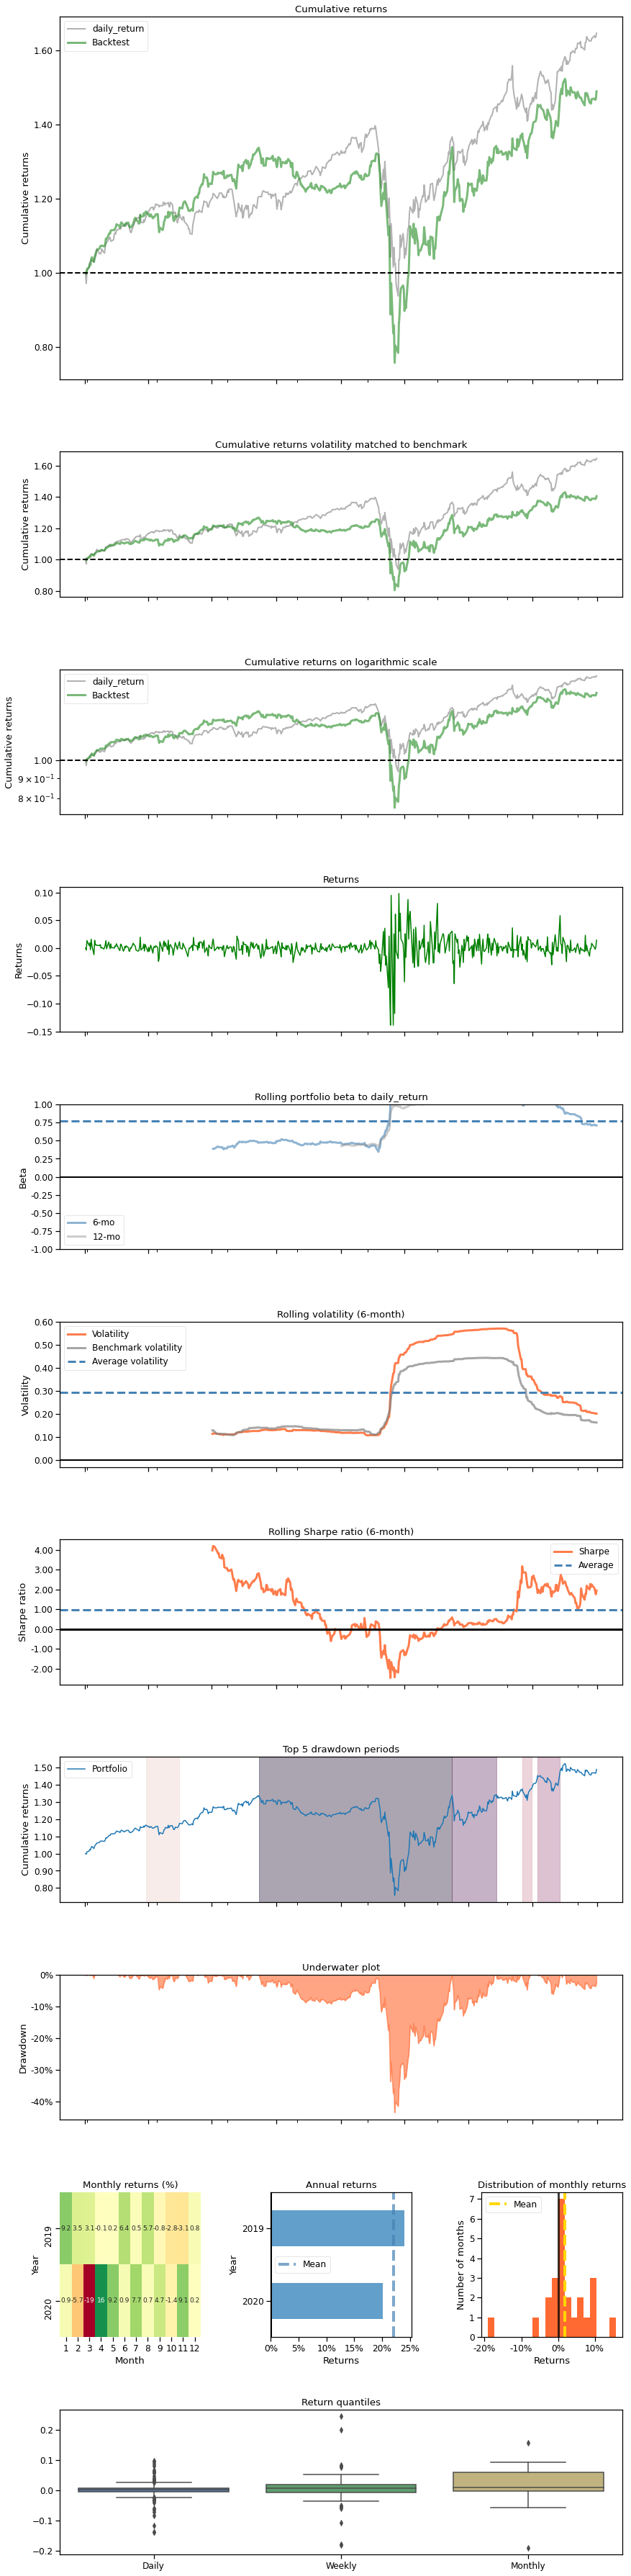

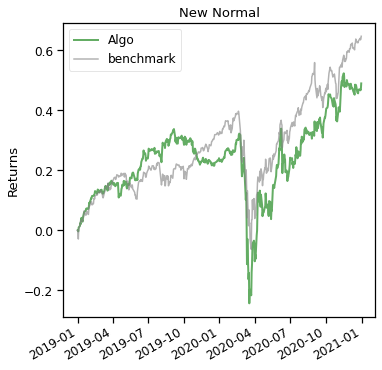

In [67]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [38]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:147760.21801846888
Sharpe:  0.8228095866470669
hit end!


In [39]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.000541
2,2019-01-04,0.013692
3,2019-01-07,0.006536
4,2019-01-08,0.006303
...,...,...
500,2020-12-24,0.008741
501,2020-12-28,-0.000161
502,2020-12-29,-0.000630
503,2020-12-30,0.002496


In [40]:
df_actions.head()

,CLX,PEG,SPGI,STE,VTR
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.178524,0.204673,0.130726,0.130726,0.355351
2019-01-04,0.139416,0.139416,0.202779,0.139416,0.378972
2019-01-07,0.244414,0.132135,0.132135,0.132135,0.359180
2019-01-08,0.106492,0.229089,0.268454,0.106492,0.289474


In [41]:
df_actions.to_csv('df_actions_ppo_5_2.csv')

In [42]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [43]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.215097
Cumulative returns      0.477602
Annual volatility       0.288523
Sharpe ratio            0.822810
Calmar ratio            0.574702
Stability               0.409439
Max drawdown           -0.374276
Omega ratio             1.205995
Sortino ratio           1.105470
Skew                   -1.650749
Kurtosis               20.446107
Tail ratio              0.955844
Daily value at risk    -0.035408
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,21.51%
Cumulative returns,47.76%
Annual volatility,28.852%
Sharpe ratio,0.82
Calmar ratio,0.57
Stability,0.41
Max drawdown,-37.428%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.43,2020-02-20,2020-03-23,2020-09-02,140
1,9.49,2019-09-06,2019-11-12,2020-02-12,114
2,6.55,2020-10-13,2020-10-30,2020-11-09,20
3,5.25,2020-09-02,2020-09-23,2020-10-02,23
4,4.30,2019-03-29,2019-04-17,2019-05-16,35


Stress Events,mean,min,max
New Normal,0.09%,-15.54%,9.37%


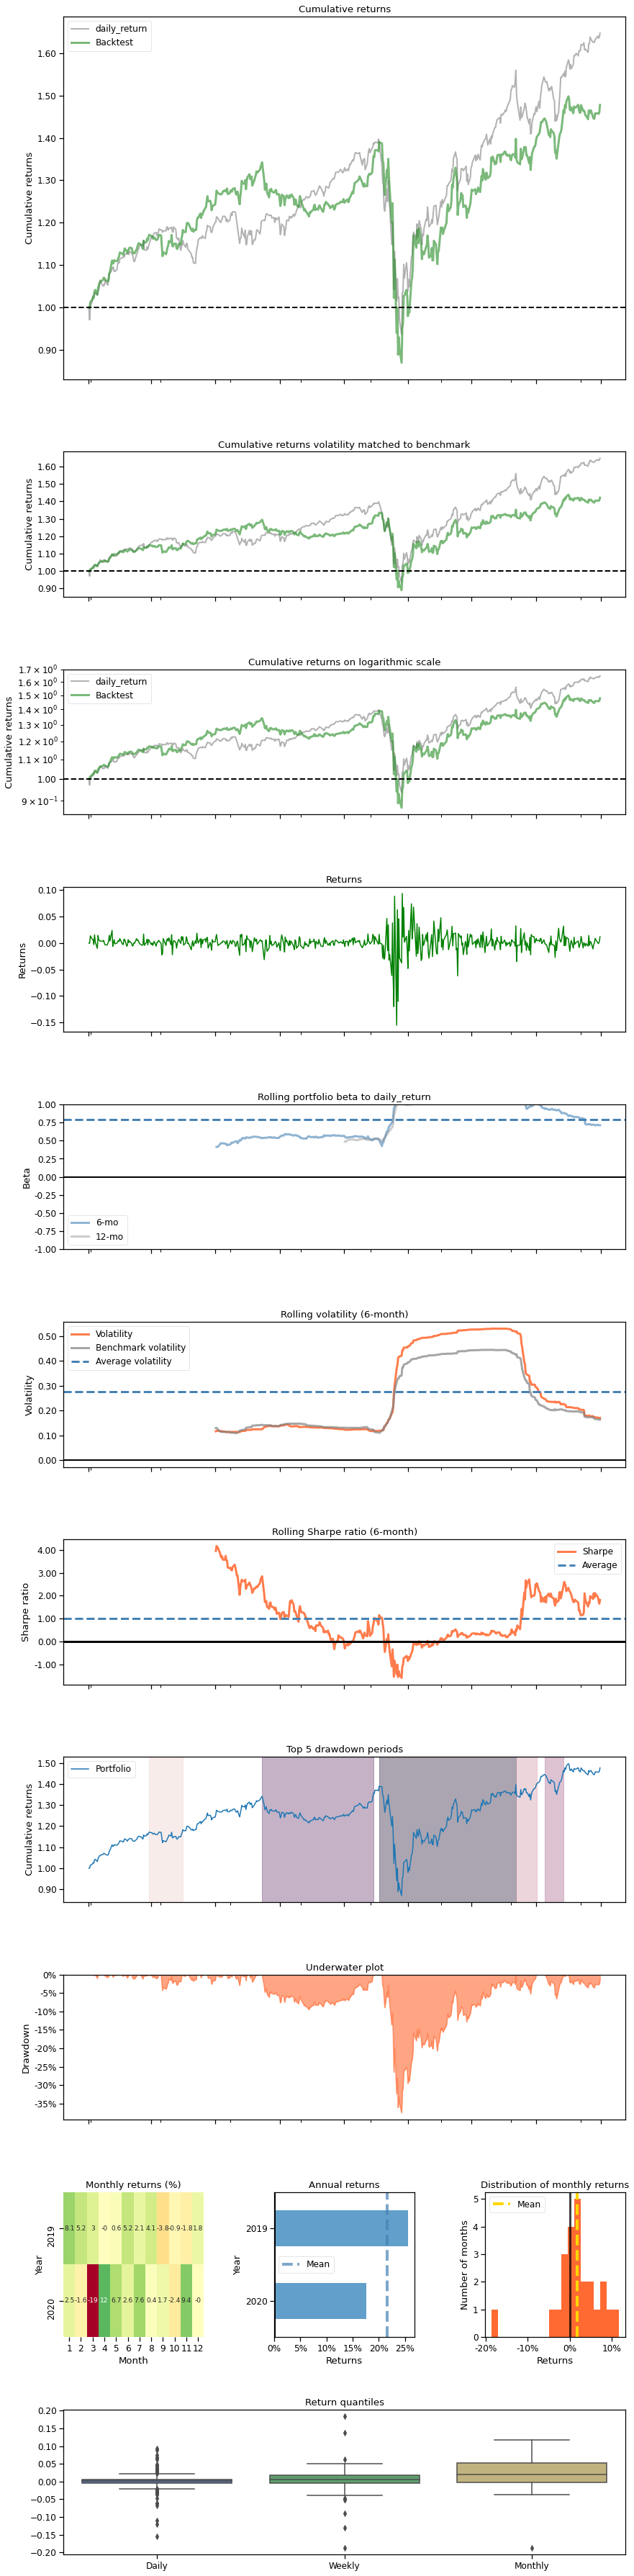

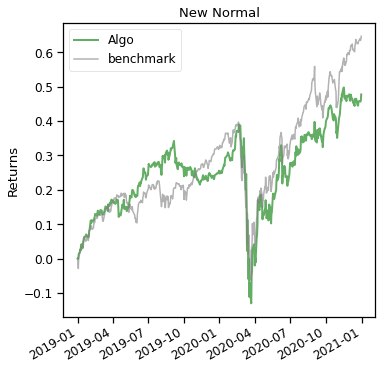

In [44]:
import pyfolio

%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)

In [45]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

begin_total_asset:100000
end_total_asset:142618.17102600995
Sharpe:  0.6972067270371544
hit end!


In [46]:
df_daily_return

,date,daily_return
0,2019-01-02,0.000000
1,2019-01-03,-0.001235
2,2019-01-04,0.012594
3,2019-01-07,0.006018
4,2019-01-08,0.005940
...,...,...
500,2020-12-24,0.007419
501,2020-12-28,0.001010
502,2020-12-29,-0.002070
503,2020-12-30,0.000413


In [47]:
df_actions

,CLX,PEG,SPGI,STE,VTR
date,,,,,
2019-01-02,0.200000,0.200000,0.200000,0.200000,0.200000
2019-01-03,0.145702,0.161548,0.152547,0.147624,0.392578
2019-01-04,0.146006,0.154167,0.166951,0.156345,0.376531
2019-01-07,0.172161,0.145175,0.146201,0.146968,0.389495
2019-01-08,0.152947,0.148119,0.155453,0.149486,0.393995
...,...,...,...,...,...
2020-12-24,0.148516,0.149819,0.150350,0.148732,0.402583
2020-12-28,0.149718,0.149761,0.149221,0.148915,0.402385
2020-12-29,0.147799,0.147803,0.155690,0.148091,0.400616


In [48]:
df_actions.to_csv('df_actions_sac_5_2.csv')

In [49]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [50]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.193809
Cumulative returns      0.426182
Annual volatility       0.337749
Sharpe ratio            0.697207
Calmar ratio            0.399767
Stability               0.114770
Max drawdown           -0.484805
Omega ratio             1.175947
Sortino ratio           0.946376
Skew                   -1.366742
Kurtosis               18.923123
Tail ratio              0.976143
Daily value at risk    -0.041618
Alpha                   0.000000
Beta                    1.000000
dtype: float64

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (506, 8)


Start date,2019-01-02
End date,2020-12-31
Total months,24
,Backtest
Annual return,19.381%
Cumulative returns,42.618%
Annual volatility,33.775%
Sharpe ratio,0.70
Calmar ratio,0.40
Stability,0.11
Max drawdown,-48.48%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,48.48,2019-09-06,2020-03-18,2020-10-06,283
1,7.68,2020-10-08,2020-10-28,2020-11-09,23
2,4.85,2019-03-29,2019-04-17,2019-05-16,35
3,4.72,2020-11-16,2020-12-14,NaT,NaN
4,3.02,2019-07-03,2019-08-05,2019-08-07,26


Stress Events,mean,min,max
New Normal,0.09%,-15.94%,11.76%


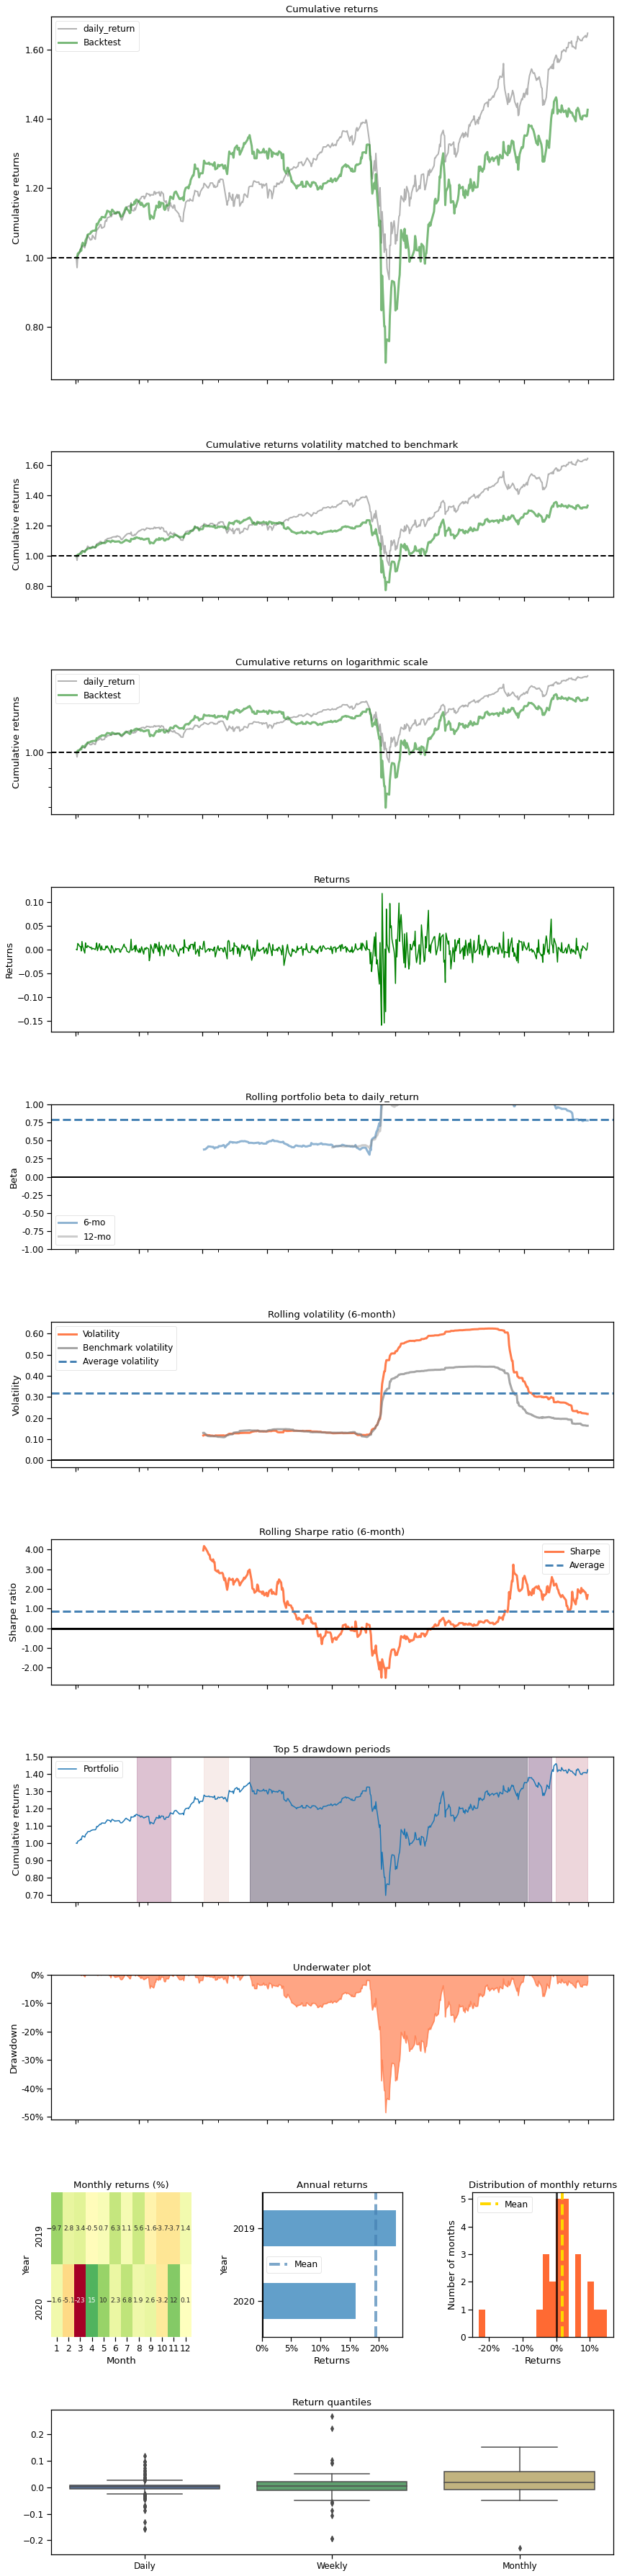

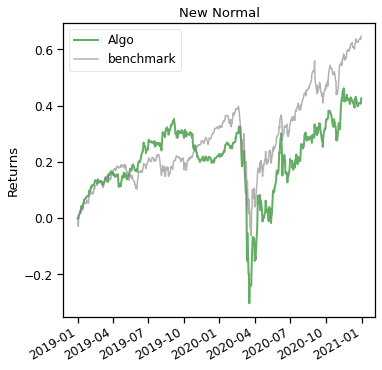

In [51]:
%matplotlib inline

baseline_df = get_baseline(
        ticker='SUSA', start='2019-01-01', end='2021-01-01'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
                                       benchmark_rets=baseline_returns, set_context=False)